# Neural Networks for Data Science Applications
## Mid-term Homework: Implementing a custom activation function



In [ ]:
import tensorflow as tf

### Introduction

The **exponential linear unit** (ELU) is an activation function defined as [1]:

$$
\phi(x) =
\Biggl\{ 
\begin{align} 
x & \;\; \text{ if } x \ge 0 \\
\alpha \left(\exp\left(x\right)- 1\right) & \;\; \text{ otherwise } 
\end{align}
\Bigr.
\,,
$$

where $\alpha$ is a hyper-parameter. The function is implemented in `tf.keras.layers.ELU` (see the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/ELU)).

The **parametric ELU** (PELU) extends the ELU activation function as [2]:

$$
\phi(x) =
\Biggl\{ 
\begin{align} 
\frac{\alpha}{\beta}x & \;\; \text{ if } x \ge 0 \\
\alpha \left(\exp\Bigl(\frac{x}{\beta}\Bigr)- 1\right) & \;\; \text{ otherwise } 
\end{align}
\Bigr.
\,,
$$

where the major difference is that $\alpha,\beta > 0$ are *trainable* parameters, i.e., a pair of $(\alpha, \beta)$ values is trained for each unit in the network.

### Exercise 1: implement the PELU

In TensorFlow, it is possible to implement new layers by subclassing `tf.keras.layers.Layer`:

+ [Making new Layers and Models via subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models)
+ [Custom layers](https://www.tensorflow.org/tutorials/customization/custom_layers)
+ [tf.keras.layers.Layer (documentation)](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer)

**Exercise 1**: *After carefully reading the guides*, complete the following implementation of the PELU activation function.

In [ ]:
class PELU(tf.keras.layers.Layer):
    def __init__(self, units=32):
        super(PELU, self).__init__()
        self.units = units


    def build(self, input_shape):

        init = tf.constant_initializer(0.1)
        self.alpha = self.add_weight('alpha',
                                    shape=[self.units],
                                    initializer= init,
                                    trainable=True,
                                    constraint= tf.keras.constraints.non_neg()
                                    )

        self.beta = self.add_weight('beta',
                                    shape=[self.units],
                                    initializer= init,
                                    trainable=True,
                                    constraint= tf.keras.constraints.non_neg()
                                    )


    def call(self, inputs):

        output = (self.alpha/self.beta)*tf.maximum(0., inputs) + self.alpha*(tf.subtract(tf.exp(tf.minimum(0., inputs)/self.beta),tf.constant(1.0)))
        return output

    def get_config(self):
        config = super(PELU, self).get_config()
        config.update({"units": self.units})

        return config


**Hints for a correct implementation**:

1. The layer (probably) requires two sets of trainable variables, whose shape depends on the number of units.
2. From the definition of the PELU, $\alpha, \beta$ are required to be positive in order to ensure differentiability. The simplest way to handle this is to use a [constraint callable](https://www.tensorflow.org/api_docs/python/tf/keras/constraints) when creating the weight (see also the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer) for `add_weight`).

### Exercise 2: some preliminary tests

To evaluate your implementation, let us start by creating a single PELU function:

In [ ]:
pelu = PELU(units=1)

**Exercise 2.1**: plot the function using the skeleton code below.

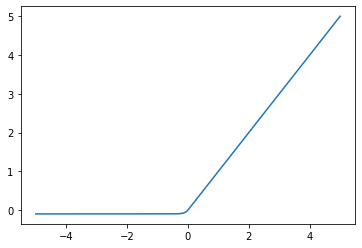

In [ ]:
import matplotlib.pyplot as plt
x_range = tf.linspace(-5, 5, 200) # An equispaced grid of 200 points in [-5, +5]
x = tf.cast(x_range, tf.float32)
y_range= pelu(x)

plt.plot(x_range.numpy(), y_range.numpy())

The derivative of a PELU function with respect to the $\alpha$ parameter is given by [2]:

$$
\frac{d\phi(x)}{d\alpha} =
\Biggl\{ 
\begin{align} 
\frac{x}{\beta} & \;\; \text{ if } x \ge 0 \\
 \left(\exp\Bigl(\frac{x}{\beta}\Bigr)- 1\right) & \;\; \text{ otherwise } 
\end{align}
\Bigr.
\,,
$$

**Exercise 2.2**: using a `tf.GradientTape` object, compute the derivative above using automatic differentiation, and check its correctness up to a certain numerical precision.

**Hints for a correct implementation**:

1. `tf.GradientTape` allows to compute the derivative *at a single point x*. If you prefer to avoid a loop over all possible points, consider using the `jacobian` function to obtain them in a single pass ([Advanced Automatic Differentiation](https://www.tensorflow.org/guide/advanced_autodiff)).
2. Given two tensors x and y, a simple way to compute elementwise similarity up to a certain precision (e.g., $10^{-4}$), is given by `tf.reduce_all(tf.abs(x - y) < 1e-4)`.

In [ ]:
# Automatic
x = tf.cast(tf.linspace(-5, 5, 200), tf.float32) # An equispaced grid of 200 points in [-5, +5]
with tf.GradientTape() as t:
    t.watch(x)
    y = pelu(x)

x_grad = t.jacobian(y, pelu.trainable_variables[0])
gradient_auto = tf.reshape(x_grad,[-1])

In [ ]:
# Manual
b = pelu.trainable_variables[1]
a = pelu.trainable_variables[0]

condition = tf.greater(x, tf.constant(0.0))
gradient_manual = tf.where(condition, (x/b), (tf.subtract(tf.exp(x/b), tf.constant(1.0)))) 

In [ ]:
# If result is True it means that the difference between the two tensors is close to 0
tf.reduce_all(tf.abs(gradient_manual - gradient_auto) < 1e-4)

<tf.Tensor: shape=(), dtype=bool, numpy=True>

**Exercise 2.3 (optional)**: try the same for the $\beta$ parameter (you can check the analytical formula for the gradient in the original paper [2]). **Careful**: the equation in the original paper has a missing $h$ (thanks to Davide Aureli and Federico Siciliano for spotting this). See [the correct derivation](https://www.wolframalpha.com/input/?i=d%28a*%28exp%28h%2Fb%29-1%29%29%2Fdb) on Wolfram Alpha.

In [ ]:
# Automatic
x = tf.cast(tf.linspace(-5, 5, 200), tf.float32) # An equispaced grid of 200 points in [-5, +5]
with tf.GradientTape() as t:
    t.watch(x)
    y = pelu(x)
x_grad_beta = t.jacobian(y, pelu.trainable_variables[1])
gradient_auto_beta = tf.reshape(x_grad_beta,[-1])

In [ ]:
# Manual computation
gradient_manual_beta = tf.where(condition, -(x*a/b**2), -(a*x*(tf.exp(x/b))/(b**2))) 

In [ ]:
# If result is True it means that the difference between the two tensors is close to 0
tf.reduce_all(tf.abs(gradient_manual_beta - gradient_auto_beta) < 1e-4)

<tf.Tensor: shape=(), dtype=bool, numpy=True>

### Exercise 3: PELU in practice

Consider a simple model built with the PELU activation function, as below.

#### Load Dataset

In [ ]:
import tensorflow_datasets as tfds
# I decided to pick the mnist dataset for our classification task
(train_data, test_data) = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

In [ ]:
# Train set
train_data = train_data.map(normalize_img)
train_data = train_data.batch(64)

In [ ]:
# Test set
test_data = test_data.map(normalize_img)
test_data = test_data.batch(64)

**Exercise 3**: load any classification dataset, and train the model above (using either a custom training loop or `model.fit(...)`). Additionally, compare with a standard ReLU activation.

#### Training with ``` model.fit() ```



In [ ]:
# Define a sequential model
def create_model():

    model1 = tf.keras.Sequential(layers=[
        tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
        tf.keras.layers.Dense(50),
        PELU(50),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model2 = tf.keras.Sequential(layers=[
        tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
        tf.keras.layers.Dense(50),
        tf.keras.layers.Activation(tf.keras.activations.relu),
        tf.keras.layers.Dense(10, activation='softmax')
    ])


    model1.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
            )
    
    model1.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
        )
    
    model2.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
        )

    return model1, model2



# Create two models we would like to compare
model_pelu, model_relu = create_model()

In [ ]:
history_pelu = model_pelu.fit(
    train_data,
    epochs=8
)

Epoch 1/8
938/938 [==============================] - 8s 9ms/step - loss: 0.3162 - accuracy: 0.9070
Epoch 2/8
938/938 [==============================] - 3s 3ms/step - loss: 0.1492 - accuracy: 0.9566
Epoch 3/8
938/938 [==============================] - 3s 3ms/step - loss: 0.1103 - accuracy: 0.9677
Epoch 4/8
938/938 [==============================] - 3s 3ms/step - loss: 0.0886 - accuracy: 0.9740
Epoch 5/8
938/938 [==============================] - 3s 3ms/step - loss: 0.0744 - accuracy: 0.9782
Epoch 6/8
938/938 [==============================] - 3s 3ms/step - loss: 0.0637 - accuracy: 0.9817
Epoch 7/8
938/938 [==============================] - 3s 3ms/step - loss: 0.0555 - accuracy: 0.9840
Epoch 8/8
938/938 [==============================] - 3s 3ms/step - loss: 0.0484 - accuracy: 0.9859


In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model_pelu.evaluate(test_data)
print("test loss, test acc:", results)

Evaluate on test data
157/157 [==============================] - 1s 8ms/step - loss: 0.1297 - accuracy: 0.9660
test loss, test acc: [0.12974905967712402, 0.9660000205039978]


In [ ]:
# Relu
history_relu = model_relu.fit(
    train_data,
    epochs=8
)

Epoch 1/8
938/938 [==============================] - 3s 3ms/step - loss: 0.3696 - accuracy: 0.8974
Epoch 2/8
938/938 [==============================] - 3s 3ms/step - loss: 0.1866 - accuracy: 0.9462
Epoch 3/8
938/938 [==============================] - 3s 3ms/step - loss: 0.1418 - accuracy: 0.9591
Epoch 4/8
938/938 [==============================] - 3s 3ms/step - loss: 0.1146 - accuracy: 0.9672
Epoch 5/8
938/938 [==============================] - 3s 3ms/step - loss: 0.0959 - accuracy: 0.9720
Epoch 6/8
938/938 [==============================] - 3s 3ms/step - loss: 0.0824 - accuracy: 0.9762
Epoch 7/8
938/938 [==============================] - 3s 3ms/step - loss: 0.0717 - accuracy: 0.9789
Epoch 8/8
938/938 [==============================] - 3s 3ms/step - loss: 0.0630 - accuracy: 0.9818


In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model_relu.evaluate(test_data)
print("test loss, test acc:", results)

Evaluate on test data
157/157 [==============================] - 0s 3ms/step - loss: 0.0985 - accuracy: 0.9688
test loss, test acc: [0.09847962111234665, 0.9688000082969666]


#### **Pelu vs Relu**, Train Set

In [ ]:
import pandas as pd

In [ ]:
new = pd.DataFrame.from_dict(history_pelu.history) 
# Shift index by one since epochs starts from 1
new.index += 1 
new = new.rename(columns = {'loss': 'Loss_pelu', 'accuracy': 'Accuracy_pelu'}, inplace = False)
new['Loss_relu'] = history_relu.history['loss']
new['Accuracy_relu'] = history_relu.history['accuracy']

In [ ]:
new

,Loss_pelu,Accuracy_pelu,Loss_relu,Accuracy_relu
1,0.316231,0.907000,0.369611,0.897450
2,0.149236,0.956600,0.186616,0.946183
3,0.110288,0.967733,0.141841,0.959100
4,0.088616,0.973967,0.114572,0.967217
5,0.074439,0.978233,0.095938,0.971967
6,0.063694,0.981683,0.082391,0.976217
7,0.055541,0.983967,0.071722,0.978883
8,0.048392,0.985900,0.062991,0.981800


Text(0, 0.5, 'Loss')

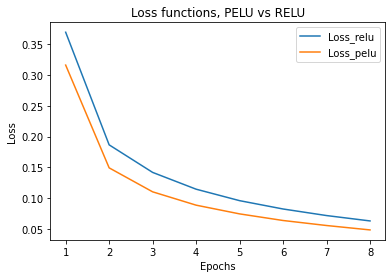

In [ ]:
plot1 = new.reset_index().plot(x='index', y=['Loss_relu', 'Loss_pelu'])
plot1.set_title('Loss functions, PELU vs RELU')
plot1.set_xlabel('Epochs') 
plot1.set_ylabel('Loss') 

Text(0, 0.5, 'Loss')

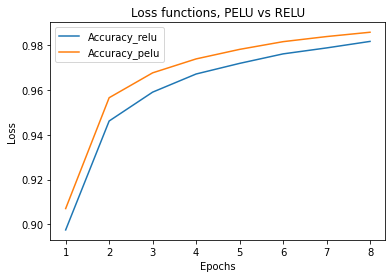

In [ ]:
plot2 = new.reset_index().plot(x='index', y=['Accuracy_relu', 'Accuracy_pelu'])
plot2.set_title('Loss functions, PELU vs RELU')
plot2.set_xlabel('Epochs') 
plot2.set_ylabel('Loss') 

#### **Pelu vs Relu**, Test Set \& Conclusions

**Pelu** seems to perform be better during the training test with respect to **Relu**, both in terms of *accuracy* and *loss*. 

But once the model has been trained the scores we get for both of them are really close.



*   Pelu:
    *   Loss = 0.1297
    *   Accuracy = 0.9660
*   Relu:
    *   Loss = 0.0985
    *   Accuracy = 0.9685


But **why** is PELU better than ELU? 

As the paper$^{[2]}$ says, the ELU activation function was created to reduce bias shift, but on the down-side the parametrization had to be hone by hand. This is where PELU comes in handy,by learning a parameterization of the ELU activation function, this helps with "different activation shapes at different locations in the network".

### Optional: understanding saving/loading of models

TensorFlow has several options for saving or loading objects from the disk:

1. [Save and load Keras models](https://www.tensorflow.org/guide/keras/save_and_serialize/)

In many cases, custom classes require the implementation of a `get_config` / `from_config` functions to define the serialization behaviour.

**Exercise 4 (optional)**: implement the `get_config` method and test your implementation as below (taken from the guide on saving and loading models).

In [ ]:
model_pelu.save('pelu_model')
del PELU # This is needed to remove any reference to PELU from memory
reloaded_model = tf.keras.models.load_model('pelu_model')

INFO:tensorflow:Assets written to: pelu_model/assets


INFO:tensorflow:Assets written to: pelu_model/assets


In [ ]:
print("Original model:", model_pelu)
print("Loaded model:", reloaded_model) # Observe that the object has been dynamically recreated in absence of the configuration options

Original model: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f846f40dd68>
Loaded model: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f846f241860>


In [ ]:
model_pelu.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 50)                39250     
_________________________________________________________________
pelu_3 (PELU)                (None, 50)                100       
_________________________________________________________________
dense_9 (Dense)              (None, 10)                510       
Total params: 39,860
Trainable params: 39,860
Non-trainable params: 0
_________________________________________________________________


In [ ]:
reloaded_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 50)                39250     
_________________________________________________________________
pelu_3 (PELU)                (None, 50)                100       
_________________________________________________________________
dense_9 (Dense)              (None, 10)                510       
Total params: 39,860
Trainable params: 39,860
Non-trainable params: 0
_________________________________________________________________


### References

[1] Clevert, D.A., Unterthiner, T. and Hochreiter, S., 2015. [Fast and accurate deep network learning by exponential linear units (ELUs)](https://arxiv.org/abs/1511.07289). arXiv preprint arXiv:1511.07289.

[2] Trottier, L., Gigu, P. and Chaib-draa, B., 2017. [Parametric exponential linear unit for deep convolutional neural networks](https://arxiv.org/abs/1605.09332). In 2017 16th IEEE International Conference on Machine Learning and Applications (ICMLA) (pp. 207-214). IEEE.